In [1]:
!pip install contractions

import pandas as pd
import contractions
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM, Dense, Dropout, GlobalMaxPool1D
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
data = pd.read_csv('../input/data-analyst-jobs/DataAnalyst.csv')
data = data[data['Salary Estimate'].str.contains('Glassdoor')]

jb = data['Job Description'].to_list()

#JOB DESCRIPTION PREPROCESS
jb = [x.replace('\n', ' ') for x in jb] #remove \n
jb = [contractions.fix(x) for x in jb] #fix contractions

def remove_punc(input_string): 
    '''
    we create our own function to keep certain signs
    '''
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for x in input_string.lower(): 
        if x in punctuations: 
            input_string = input_string.replace(x, ' ')             
    return input_string

jb = [remove_punc(x) for x in jb] #remove punctuations
jb = [re.sub(' +', ' ', x) for x in jb] #remove extra spaces in strings

stpw = stopwords.words('english')

def remove_stpw(input_string):
    output_string = []
    for i in input_string.split():
        if i.strip().lower() not in stpw:
            output_string.append(i.strip())
    return ' '.join(output_string)

jb = [remove_stpw(x) for x in jb] #remove stopwords
jb = [x.lower() for x in jb]

salary = data['Salary Estimate'].to_list()

salary_avg = [] #use average salary estimate as dependent variable
for i in salary:
    lower = i[i.find('$')+1:i.find('K')]
    upper = i[i.rfind('$')+1:i.rfind('K')]
    avg = (int(lower) + int(upper)) / 2
    salary_avg.append(avg)

In [3]:
#VECTORIZE
embed_size = 100
maxlen = 1000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(jb)

X = tokenizer.texts_to_sequences(jb)
X = pad_sequences(X, maxlen = maxlen)

y = salary_avg.copy()
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#GLOVE EMBEDDING
embedding_path = '../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'

embeddings_index = {}
f = open(embedding_path)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [4]:
#BUILD AND TRAIN MODEL
model = Sequential()
model.add(Embedding(len(word_index) + 1, embed_size, weights=[embedding_matrix]))
model.add(LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(GlobalMaxPool1D())
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', 
              metrics = ['mse'])

es = EarlyStopping(monitor='val_mse', mode='min', verbose=1)
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=1000, callbacks=[es])

Epoch 1/1000
45/45 [==============================] - 71s 2s/step - loss: 4840.0068 - mse: 4840.0068 - val_loss: 4653.2803 - val_mse: 4653.2803
Epoch 2/1000
45/45 [==============================] - 71s 2s/step - loss: 4203.6821 - mse: 4203.6821 - val_loss: 4167.4312 - val_mse: 4167.4312
Epoch 3/1000
45/45 [==============================] - 71s 2s/step - loss: 3618.9094 - mse: 3618.9094 - val_loss: 3350.8313 - val_mse: 3350.8313
Epoch 4/1000
45/45 [==============================] - 71s 2s/step - loss: 2697.1265 - mse: 2697.1265 - val_loss: 2438.0767 - val_mse: 2438.0767
Epoch 5/1000
45/45 [==============================] - 72s 2s/step - loss: 2041.1173 - mse: 2041.1173 - val_loss: 1943.7292 - val_mse: 1943.7292
Epoch 6/1000
45/45 [==============================] - 71s 2s/step - loss: 1654.4843 - mse: 1654.4843 - val_loss: 1607.8386 - val_mse: 1607.8386
Epoch 7/1000
45/45 [==============================] - 71s 2s/step - loss: 1378.4154 - mse: 1378.4154 - val_loss: 1355.5043 - val_mse: 13

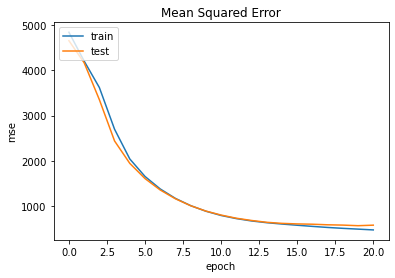

In [5]:
#PLOT TRAINING HISTORY
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
#TESTING
y_predict = model.predict(X_test, verbose=1)
mean_squared_error(y_test, y_predict)

15/15 [==============================] - 3s 176ms/step


593.3597389458822